# Final Project: Trending Youtube Video Statistic

## Introduction
Every video marketer knows that amassing views on YouTube is vital to their success/earnings.
However, the biggest factor that determines how much YouTube will pay is the cost per impression (CPI).

These are part of the factors that YouTube taking into account on CPI:
- The type of audience viewing your video
- The ads themselves
- The price of the ads
- Audience retention
- Engagement

Hence, getting listed into daily YouTube trend will be helpful in improving CPI of video marketer.

## Dataset Background
Top 200 daily trending Youtube videos in 5 regions from 14th November 2017 to 5th March 2018

## Problem Statement
With features available in the datasets, to predict how many times a video get listed in Youtube Trend in different regions

## Part 1: Data Cleaning and Features & Target Variable Derivation

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
#glob is used to read files in any similar format in the same folder path
csv_files = [x for x in glob.glob('../GA_Project4_Draft/*.{}'.format('csv'))]

videos = []
country_list = []
for csv in csv_files:
    original_videos = pd.read_csv(csv, index_col=None)
    original_videos['country'] = csv[21:23]
    country_list.append(csv[21:23])
    videos.append(original_videos) #add original_videos (dataframe) into videos (list)

all_videos = pd.concat(videos)

In [6]:
print(country_list)

['CA', 'DE', 'FR', 'GB', 'US']


In [7]:
all_videos1 = all_videos.drop(['thumbnail_link','description'],axis=1)
all_videos1['trending_date'] = pd.to_datetime(all_videos1['trending_date'],format='%y.%d.%m')
all_videos1['publish_time'] = pd.to_datetime(all_videos1['publish_time'],format='%Y-%m-%dT%H:%M:%S.%fZ')
all_videos1.insert(4,'publish_date',all_videos1['publish_time'].dt.date)
all_videos1['publish_time'] = all_videos1['publish_time'].dt.time
all_videos1['publish_date'] = pd.to_datetime(all_videos1['publish_date'])
all_videos1['tags'] = all_videos1['tags'].apply(lambda x: x.replace('"',''))
all_videos1['tags'] = all_videos1['tags'].apply(lambda x: x.replace('/','|'))
all_videos1['refined_tags'] = all_videos1.tags.map(lambda x: [i.strip() for i in x.split("|")])
#if 'tags' is not a list, need to parse it and convert it into a list
#strip will remove selected characters
#split will split out Eminen|walk to ['Eminen','walk']
all_videos1['number_of_tags'] = all_videos1.refined_tags.apply(len)
all_videos1['net_likes_dislikes'] = all_videos1['likes']
all_videos1['net_likes_dislikes'] = all_videos1[['net_likes_dislikes']].sub(all_videos1['dislikes'],axis=0)
all_videos1['publish_hour'] = all_videos1['publish_time'].astype(str).str[:2]
#calculate trend_publish_diff in days
all_videos1['trend_publish_diff'] = (all_videos1['trending_date'] - all_videos1['publish_date']).dt.days

In [4]:
all_videos1 = pd.read_csv('../GA_Project4_Draft/all_videos1.csv')
all_videos1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202310 entries, 0 to 202309
Data columns (total 22 columns):
Unnamed: 0                202310 non-null int64
video_id                  202310 non-null object
trending_date             202310 non-null object
title                     202310 non-null object
channel_title             202310 non-null object
publish_date              202310 non-null object
category_id               202310 non-null int64
publish_time              202310 non-null object
tags                      202310 non-null object
views                     202310 non-null int64
likes                     202310 non-null int64
dislikes                  202310 non-null int64
comment_count             202310 non-null int64
comments_disabled         202310 non-null bool
ratings_disabled          202310 non-null bool
video_error_or_removed    202310 non-null bool
country                   202310 non-null object
refined_tags              202310 non-null object
number_of_tags     

In [19]:
# create a dictionary of dataframe that is classified by country
d = {}
for i in range(0,len(country_list)):
    d[country_list[i]] = all_videos1[all_videos1.country == country_list[i]]

In [20]:
j = {}    
for i in country_list:
    # (1) groupby video_id and select min trend_publish_diff
    idx = d[i].groupby(['video_id'])['trend_publish_diff'].transform(min) == d[i]['trend_publish_diff']
    # (2) get the filtered dataframe
    j[i] = d[i][idx] #grouped dataframe
    # (3) get the series value on trend count based on original dataframe
    trend_count = d[i].video_id.value_counts()
    # (4) convert series from (3) to dataframe
    count_df = pd.DataFrame({'id':trend_count.index,'trend_count':trend_count.values})
    # (5) merge (2) and (4)
    j[i] = pd.merge(j[i],count_df,how='inner',left_on='video_id',right_on='id')
    j[i].drop(['id'],axis=1,inplace=True)

In [21]:
videos_byregion = []
for i in country_list:
    all_videos3 = pd.DataFrame.from_dict(j[i])
    videos_byregion.append(all_videos3)

final_videos = pd.concat(videos_byregion)
final_videos.head()

,video_id,trending_date,title,channel_title,publish_date,category_id,publish_time,tags,views,likes,...,comments_disabled,ratings_disabled,video_error_or_removed,country,refined_tags,number_of_tags,net_likes_dislikes,publish_hour,trend_publish_diff,trend_count
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,2017-11-10,10,17:00:03,Eminem|Walk|On|Water|Aftermath|Shady|Interscop...,17158579,787425,...,False,False,False,CA,"[Eminem, Walk, On, Water, Aftermath, Shady, In...",8,744005,17,4,4
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,2017-11-13,23,17:00:00,plush|bad unboxing|unboxing|fan mail|idubbbztv...,1014651,127794,...,False,False,False,CA,"[plush, bad unboxing, unboxing, fan mail, idub...",11,126106,17,1,5
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,2017-11-12,23,19:05:24,racist superman|rudy|mancuso|king|bach|racist|...,3191434,146035,...,False,False,False,CA,"[racist superman, rudy, mancuso, king, bach, r...",23,140696,19,2,4
3,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,2017-11-12,24,18:01:41,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,2095828,132239,...,False,False,False,CA,"[ryan, higa, higatv, nigahiga, i dare you, idy...",14,130250,18,2,4
4,2Vv-BfVoq4g,2017-11-14,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,2017-11-09,10,11:04:14,edsheeran|ed sheeran|acoustic|live|cover|offic...,33523622,1634130,...,False,False,False,CA,"[edsheeran, ed sheeran, acoustic, live, cover,...",10,1613048,11,5,2


In [22]:
final_videos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94327 entries, 0 to 6374
Data columns (total 22 columns):
video_id                  94327 non-null object
trending_date             94327 non-null datetime64[ns]
title                     94327 non-null object
channel_title             94327 non-null object
publish_date              94327 non-null datetime64[ns]
category_id               94327 non-null int64
publish_time              94327 non-null object
tags                      94327 non-null object
views                     94327 non-null int64
likes                     94327 non-null int64
dislikes                  94327 non-null int64
comment_count             94327 non-null int64
comments_disabled         94327 non-null bool
ratings_disabled          94327 non-null bool
video_error_or_removed    94327 non-null bool
country                   94327 non-null object
refined_tags              94327 non-null object
number_of_tags            94327 non-null int64
net_likes_dislikes      

### Summary of dataframe:
- "all_videos1" dataframe has all rows and columns with all data cleaned up
- "final_videos" dataframe is grouped by country with the row of video id that get trended in the shortest period of time from publish date

In [23]:
# all_videos1 dataframe has all rows and columns with all data cleaned up
df1 = pd.DataFrame(all_videos1)
df1.to_csv('all_videos1.csv')

In [24]:
# final_videos is grouped by country with the row of video id that get trended in the shortest period of time from publish date
df2 = pd.DataFrame(final_videos)
df2.to_csv('final_videos.csv')

## Part 2: Exploratory Data Analysis (EDA)

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
%matplotlib inline

all_videos1 = pd.read_csv('../GA_Project4_Draft/all_videos1.csv')
final_videos = pd.read_csv('../GA_Project4_Draft/final_videos.csv')

### 1. How many likes, dislikes, views and comments get by different countries?
- For likes, views and comment_counts, all countries share the same ratio in all categories.
- DE gives relatively more dislikes compared to its likes count.
- Likes, views and comment_count are strongly correlated to each other while correlation with dislikes is comparatively lower.
- GB and US do not give high counts in likes, dislikes, views and comment_count when the video first get trended.
- But as videos get trended, GB and US contribute more in increasing likes, dislikes, views and comment_count.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000007817BAB9E8>,
      dtype=object)

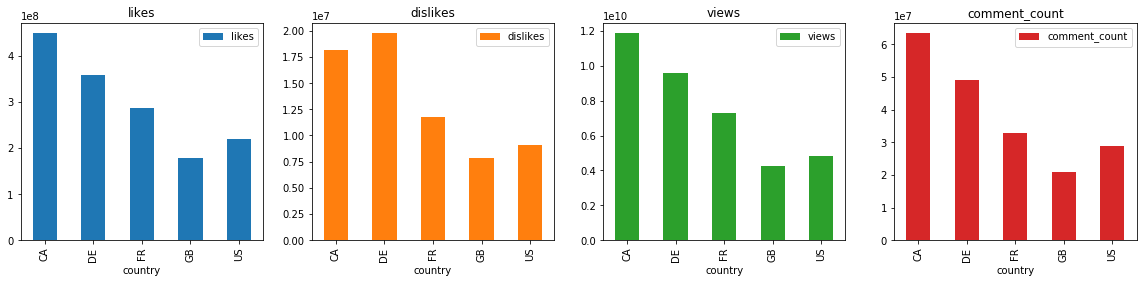

In [2]:
final_videos1 = final_videos.groupby('country')['likes','dislikes','views','comment_count'].sum()
final_videos1.plot(kind='bar',subplots=True,layout=(1,4),figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000780883F2E8>,
      dtype=object)

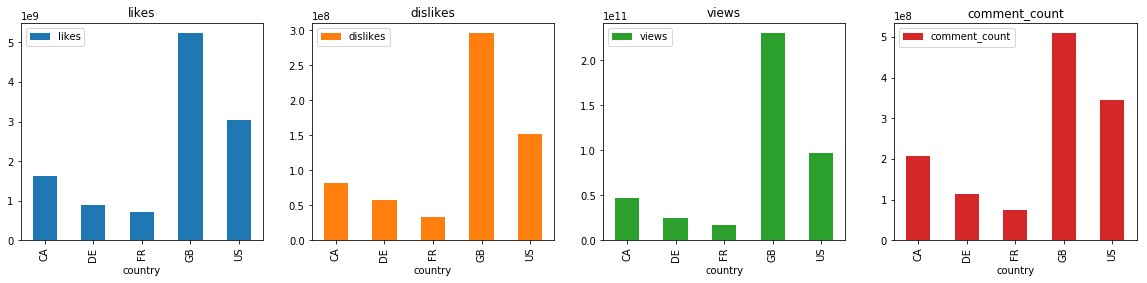

In [3]:
all_videos2 = all_videos1.groupby('country')['likes','dislikes','views','comment_count'].sum()
all_videos2.plot(kind='bar',subplots=True,layout=(1,4),figsize=(20,4))

### 2. Is there any correlation between total number of videos on trending list and average video trend count in different countries?
Countries that give higher video average trend count, have lower total video count on trending list

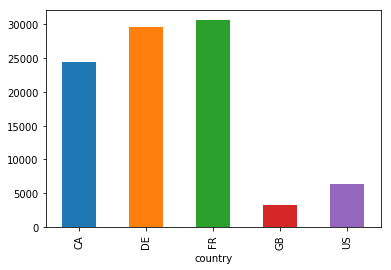

In [7]:
final_videos6 = final_videos.groupby('country')['video_id'].count()
final_videos7 = final_videos.groupby('country')['trend_count'].mean()
final_videos6.plot(kind='bar')

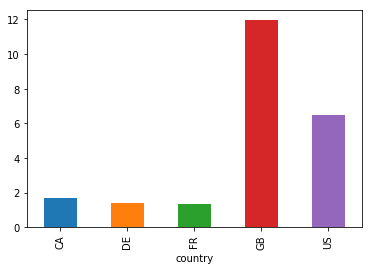

In [8]:
final_videos7.plot(kind='bar')

### 3. Does publish hour affect how many times videos get trended?
- Overall data shows that publish_hour at 1600 gives highest trend_count.
- publish_hour from 2300 to 1100 generally has lower trend_count.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000007809904BE0>,
      dtype=object)

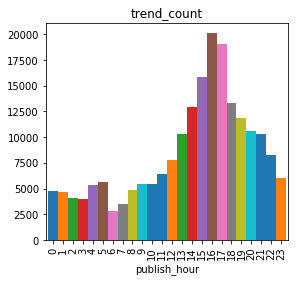

In [9]:
final_videos2 = final_videos.groupby('publish_hour')['trend_count'].sum()
final_videos2.plot(kind='bar',subplots=True,layout=(1,4),figsize=(20,4),width=1.0)

### 4. Do videos that disable ratings and comments functions have lower possibility of getting trended?
- Only 2% of comments_disabled videos get trended.
- Only 1% of ratings_disabled videos get trended.

In [12]:
final_videos4 = final_videos.groupby('comments_disabled')['trend_count'].sum()
final_videos4

comments_disabled
False    199512
True       3796
Name: trend_count, dtype: int64

In [11]:
final_videos5 = final_videos.groupby('ratings_disabled')['trend_count'].sum()
final_videos5

ratings_disabled
False    201279
True       2029
Name: trend_count, dtype: int64

### Pairplot/Heatmap

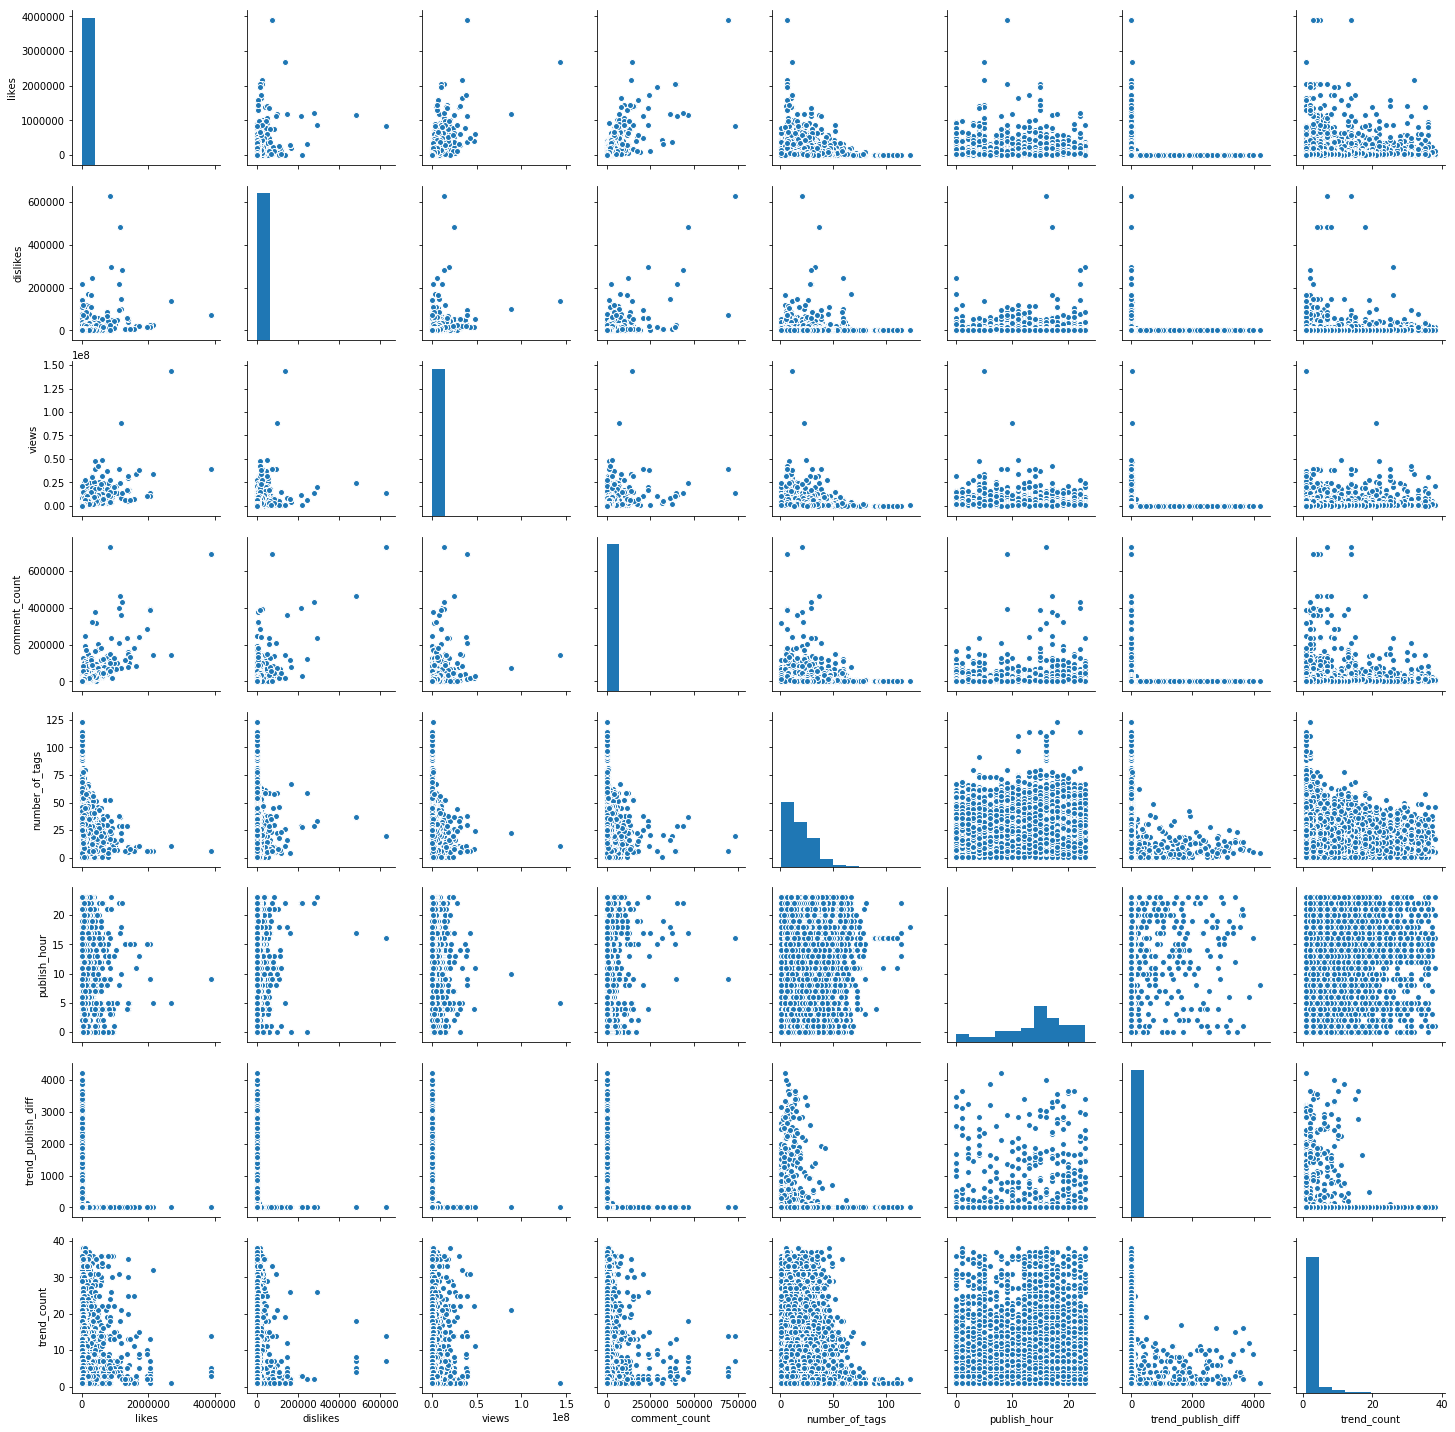

In [13]:
feature_cols1 =['likes', 'dislikes', 'views', 'comment_count','number_of_tags','publish_hour','trend_publish_diff','trend_count']
sns.pairplot(final_videos[feature_cols1])

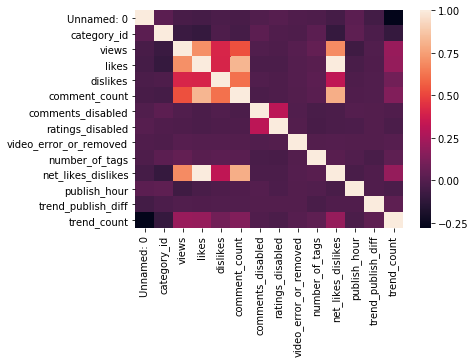

In [14]:
sns.heatmap(final_videos.corr())

#### Feature Selection (based on the above analysis)
- likes
- dislikes
- views 
- comment_count
- publish_hour 
- number_of_tags

## Part 3: Data Modelling on Linear Regression

In [33]:
country_dummies = pd.get_dummies(final_videos.country, prefix='country')
country_dummies.drop(country_dummies.columns[0], axis=1, inplace=True)
finalvideoss = pd.concat([final_videos, country_dummies], axis=1)
finalvideoss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94327 entries, 0 to 94326
Data columns (total 25 columns):
Unnamed: 0                94327 non-null int64
video_id                  94327 non-null object
trending_date             94327 non-null object
title                     94327 non-null object
channel_title             94327 non-null object
publish_date              94327 non-null object
publish_time              94327 non-null object
tags                      94327 non-null object
views                     94327 non-null int64
likes                     94327 non-null int64
dislikes                  94327 non-null int64
comment_count             94327 non-null int64
comments_disabled         94327 non-null bool
ratings_disabled          94327 non-null bool
video_error_or_removed    94327 non-null bool
country                   94327 non-null object
refined_tags              94327 non-null object
number_of_tags            94327 non-null int64
publish_hour              94327 non-nul

In [34]:
feature_cols = ['country_DE','country_FR','country_GB','country_US','likes', 'dislikes', 'views', 'comment_count','publish_hour','number_of_tags']
X = finalvideoss[feature_cols]
y = finalvideoss.trend_count

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

### Train-test split + KFold Cross Validation

In [35]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, random_state=123, test_size=0.33)

In [36]:
print(cross_val_score(lr, Xs_train,y_train, cv=5))
print(np.mean(cross_val_score(lr, Xs_train,y_train, cv=5)))

[0.55712792 0.54895112 0.53625674 0.52135504 0.49428931]
0.531596025386026


### Train-test split + Repeated KFold Cross Validation

In [37]:
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=123) 

print(cross_val_score(lr, Xs_train,y_train, cv=kf))
print(np.mean(cross_val_score(lr, Xs_train,y_train, cv=kf)))

[0.53199523 0.52846604 0.53262128 0.53922091 0.54041594 0.53142308
 0.54047234 0.52877932 0.5373901  0.53315074 0.5333889  0.53176807
 0.52413246 0.55147456 0.53103608 0.52459399 0.53601156 0.54974253
 0.53863009 0.52031558 0.5457473  0.53533878 0.53116131 0.52953646
 0.52783526 0.53433041 0.54547403 0.54685876 0.51444252 0.52587389
 0.52910869 0.53294439 0.51875716 0.54999543 0.54062634 0.54530673
 0.53919699 0.55535475 0.50096128 0.52756459 0.54616124 0.53232097
 0.51883386 0.54619478 0.52576759 0.51421214 0.51131856 0.52882812
 0.57179525 0.53931724]
0.5339238717438896


### Model Fitting and Prediction

In [22]:
model = lr.fit(Xs_train, y_train)
y_pred_val = lr.predict(Xs_train)
print(np.sqrt(metrics.mean_squared_error(y_train, y_pred_val)))

2.1531180916207897


In [23]:
y_pred = lr.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

2.1490126846315873


In [24]:
list(zip(feature_cols, lr.coef_))

[('country_DE', -0.12087541724283785),
 ('country_FR', -0.1452915324808175),
 ('country_GB', 1.872370586107192),
 ('country_US', 1.2045910513337565),
 ('likes', 0.46262863012261457),
 ('dislikes', 0.08763216594171196),
 ('views', 0.08575911939253048),
 ('comment_count', -0.23380754651644894),
 ('publish_hour', 0.0660568185324114),
 ('number_of_tags', -0.020342432537668962)]

In [25]:
model.score(Xs_test, y_test)

0.518515615285919

#### Residual Plot
Data points are not scattered, indicating linear regression does not fit for the datasets.
However, there is no any polynomial trending shown too.

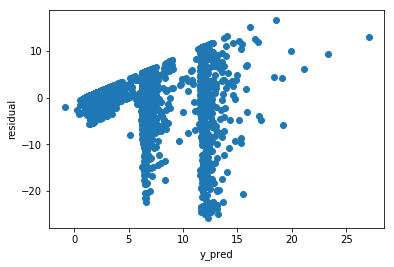

In [27]:
residual = y_pred - y_test
plt.scatter(y_pred,residual)
plt.xlabel("y_pred")
plt.ylabel("residual")
plt.show()

In [28]:
import statsmodels.api as sm
model1 = sm.OLS(y_train,Xs_train)
results = model1.fit()
print(results.summary())

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:            trend_count   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     3620.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        21:43:55   Log-Likelihood:            -1.6024e+05
No. Observations:               63199   AIC:                         3.205e+05
Df Residuals:                   63189   BIC:                         3.206e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1166      0.015     -7.762      0.0

## Part 4: Categorisation of Trend Count for Classification Prediction
For trend_count_type, videos will be classified as HIGH for trend_count higher than 5, while LOW for trend_count lower than 6.
- '0' indicates LOW
- '1' indicates HIGH

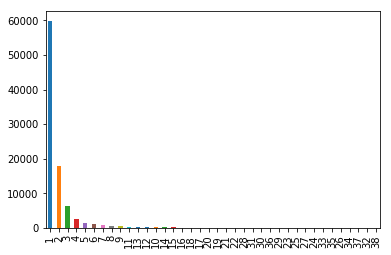

In [12]:
q = final_videos.trend_count.value_counts()
q.plot(kind='bar')

In [38]:
finalvideoss['trend_count_type'] = pd.cut(finalvideoss.trend_count, [-np.inf, 5, np.inf], labels=('0','1'))
# 0 indicates Low, while 1 indicates high
finalvideoss.trend_count_type.value_counts()

0    88372
1     5955
Name: trend_count_type, dtype: int64

## Part 5: Imbalanced Datasets

In [43]:
X1 = finalvideoss[feature_cols]
y1 = finalvideoss.trend_count_type

In [44]:
Xs1 = ss.fit_transform(X1)

In [50]:
Xs1_train, Xs1_test, y1_train, y1_test = train_test_split(Xs1, y1, random_state=123, test_size=0.4)

In [51]:
from imblearn.combine import SMOTETomek
st = SMOTETomek(random_state=123)

Xs1_train_res, y1_train_res = st.fit_sample(Xs1_train, y1_train)

In [52]:
print (Xs1_train.shape)
print (Xs1_train_res.shape)
print (y1_train.shape)
print (y1_train_res.shape)
print (Xs1_test.shape)
print (y1_test.shape)

(56596, 10)
(105834, 10)
(56596,)
(105834,)
(37731, 10)
(37731,)


In [53]:
print (sum(y1_train=='0'))
print (sum(y1_train=='1'))
print (sum(y1_train_res=='0'))
print (sum(y1_train_res=='1'))

53018
3578
52917
52917


## Part 6: Data Modelling on Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression
lo_reg = LogisticRegression()

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

print(cross_val_score(lo_reg, Xs1_train_res,y1_train_res, cv=5))
print(np.mean(cross_val_score(lo_reg, Xs1_train_res,y1_train_res, cv=5)))

[0.96763983 0.96844293 0.96867618 0.96947935 0.96990456]
0.9688285725641796


In [56]:
lo_reg.fit(Xs1_train_res,y1_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
y1_pred_val = lo_reg.predict(Xs1_train_res)
y1_pred = lo_reg.predict(Xs1_test)
print(np.sqrt(metrics.mean_squared_error(y1_train_res, y1_pred_val)))
print(np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))

0.17625981060501122
0.21132495967977374


In [58]:
from sklearn.metrics import recall_score

print ('Validation Results')
print (lo_reg.score(Xs1_train_res,y1_train_res))
print (recall_score(y1_train_res, y1_pred_val, pos_label='1'))
print (recall_score(y1_train_res, y1_pred_val, pos_label='0'))

Validation Results
0.9689324791654855
0.9804599656065158
0.9574049927244552


In [59]:
print ('Test Results')
print (lo_reg.score(Xs1_test, y1_test))
print (recall_score(y1_test, y1_pred, pos_label='1'))
print (recall_score(y1_test, y1_pred, pos_label='0'))

Test Results
0.955341761416342
0.9764408918805216
0.9539231770096736


In [60]:
from sklearn.metrics import classification_report
print (classification_report(y1_train_res, y1_pred_val))

             precision    recall  f1-score   support

          0       0.98      0.96      0.97     52917
          1       0.96      0.98      0.97     52917

avg / total       0.97      0.97      0.97    105834



In [61]:
print (classification_report(y1_test, y1_pred))

             precision    recall  f1-score   support

          0       1.00      0.95      0.98     35354
          1       0.59      0.98      0.73      2377

avg / total       0.97      0.96      0.96     37731



In [62]:
metrics.confusion_matrix(y1_test, y1_pred)

array([[33725,  1629],
       [   56,  2321]], dtype=int64)

In [63]:
metrics.confusion_matrix(y1_train_res, y1_pred_val)

array([[50663,  2254],
       [ 1034, 51883]], dtype=int64)

## Part 7: Comments, insights and data-driven conclusions
- The country that videos first get listed in YouTube trend plays an important role in deciding its subsequent frequency of getting trended.
- Compared to other feature variables, 'likes' contributes the most to the trend count of a video after getting trended for the first time.
- With existing feature variables available, we are not able to predict the video's trend count with high accuracy.
- However, we are able to predict if the video has high or low trend count with the feature variables.

### Recommendations/Work-in-progress:
To improve the accuracy of prediction model, we can:
- derive frequency of a Youtube video title containing one of its tags
- get information about the YouTube video's channel and the number of YouTube users subscribed to the channel